This code is ment to reshape the 1024 count decay curve into a 256 count decay curve (taking the old data shape and turning into the new data shape)

In [1]:
import numpy as np
import statistics
import matplotlib.pyplot as plt
import os
import zipfile

import h5py

def read_data(final_name):
    
    dataHDF5 = h5py.File(final_name, 'r')['\\1']

    # Read relevant values from data (hdf5)
    attr1 = 'Sync_rate'
    attr2 = 'block length'
    attr3 = 'Image Size X'
    attr4 = 'Image Size Y'
    attr5 = 'X start'
    attr6 = 'X end'
    attr7 = 'Y start'
    attr8 = 'Y end'
    attr9 = 'Z position'
    attr10 = 'TAC Gain'

    syncRate = dataHDF5.attrs[attr1]
    blockLength = dataHDF5.attrs[attr2]
    sizeX = dataHDF5.attrs[attr3]
    sizeY = dataHDF5.attrs[attr4]
    startX = dataHDF5.attrs[attr5]
    endX = dataHDF5.attrs[attr6]
    startY = dataHDF5.attrs[attr7]
    endY = dataHDF5.attrs[attr8]
    zPosition = dataHDF5.attrs[attr9]
    TAC_gain = dataHDF5.attrs[attr10]
    collectionTime = dataHDF5.attrs['Collection Time [s]']

    bin_file = final_name[:-5] + '_D1.bin'

    with open(bin_file, 'rb') as fileID:
        ncols = sizeX  # Define number of columns
        nrows = sizeY * blockLength  # Define number of rows
        sizeA = (nrows, ncols)  # Dimension of the *bin file
        dataFour = np.fromfile(fileID, dtype='>i', count=nrows*ncols)
        dataFour = dataFour.reshape(sizeA)

        dataBIN = dataFour.flatten()
        #dataBIN = dataBIN.astype(float)
        nPoints = np.intc(sizeX * sizeY * blockLength)
        diffPoints = len(dataBIN) - nPoints
        if diffPoints > 0:
            dataBIN = dataBIN[:nPoints]
        elif diffPoints < 0:
            dataBIN = np.concatenate((dataBIN, np.zeros(-diffPoints, dtype=np.uint32)))

        dataBIN[:3] = 0
        dataBIN = dataBIN.reshape((blockLength, sizeX * sizeY))
        dataBIN = dataBIN.reshape((sizeX, sizeY, blockLength))
        dataBIN = np.transpose(dataBIN, (1, 0, 2))


        dataHDF5 = np.sum(dataBIN, axis=2)
    

    return dataBIN

def reshape_to_256(dataBIN):
    soma = []
    matrix_256 = np.zeros((dataBIN.shape[0], dataBIN.shape[1], 256))

    for i in range(dataBIN.shape[0]):
        for j in range(dataBIN.shape[1]):
            matrix_1024 = dataBIN[i, j, :]

            # 1024 = 4 x 256

            count = 0
            for x in range(0, len(matrix_1024), 4):  # Iterate over every 4 values in matrix_1024
                soma.append(sum(matrix_1024[x:x+4]))
                count += 1
                if count == 256:  
                    matrix_256[i, j, :] = soma
                    soma.clear()

    print(matrix_256.shape)
    return matrix_256

    

def get_first_non_zero_number(numbers):
    for num in numbers:
        if num != 0:
            return num
    return None  # Return None if no non-zero number is found


def plot_curve_for_each_pixel(dataBIN):
    
    coordinates = []
    
    for i in range(dataBIN.shape[0]):
        for j in range(dataBIN.shape[1]):
            matrix_2d = dataBIN[i, j, :]
            y_row = matrix_2d.tolist()  # Convert the row to a list
            x = np.linspace(0, 12.5, num=len(y_row))
           
            total_counts = sum(matrix_2d)
        
            if total_counts < 100: #threshold = 400 cts
                continue  # Skip to the next pixel if the threshold is not met   
                
            #plt.plot(x, y_row)
            #plt.title('Before Normalization')
            #plt.show()
            
            max_value = max(y_row)
            min_value = get_first_non_zero_number(y_row)


            norm_num = []

            for val in y_row:
                norm_num.append(val)
                if val >= max_value:  # stop adding values if val >= max_value
                    break

            last_zero_index = len(norm_num) - norm_num[::-1].index(0) - 1

            min_index = norm_num.index(min_value)

            new_list = norm_num[min_index: last_zero_index + 2]
            media = statistics.mean(new_list)

            novo_y_2 = []
            novo_y_2_sem_zeros = []

            # Subtract mean from all values in y_ex
            novo_y_2 = [float(i) - media for i in y_row]

            # Set negative numbers to 0
            for y in novo_y_2:
                if y < 0:
                    y = 0
                novo_y_2_sem_zeros.append(y)

            max_value = max(novo_y_2)
            min_value = min(novo_y_2)

            norm_y_ex = []

            for val in novo_y_2:
                norm_val = (val - min_value) / (max_value - min_value)
                norm_y_ex.append(norm_val)

            # Cortar o gráfico do máximo até 10ns

            max_value = max(norm_y_ex)
            max_index = norm_y_ex.index(max_value)
            start_index = max_index
            end_index = start_index + int(9 / (x[1] - x[0]))  # Calculate end index based on time step
            
            norm_final = norm_y_ex[start_index:end_index]
            
            if len(norm_final) < 183:
            # Pad with zeros to reach the desired length
                norm_final = np.pad(norm_final, (0, 183 - len(norm_final)), mode='constant')
                
            if folder == './damaged':
                norm_final = np.append(norm_final, [0])
                
            if folder == './not_damaged':
                norm_final = np.append(norm_final, [1])
                
            norm_final = np.float32(norm_final)

            all_norm_final.append(norm_final)
            
    

folders = ['./damaged','./not_damaged']
all_norm_final = []

for folder in folders: 
    files = os.listdir(folder)
    #print(files)
    for i in files:
        if i[-4:] == 'hdf5':
            final_name = folder + '/' + i
            print(final_name)
            dataHDF5 = read_data(final_name)
            new_data = reshape_to_256(dataHDF5)
            plot_curve_for_each_pixel(new_data)
            
            
# After processing all the files, convert the list of arrays to a matrix
if len(all_norm_final) > 0:
    matrix = np.vstack(all_norm_final)
    np.save('./new_matrix_final/reshaped_matrix_256_100.npy', matrix) #name of the results file should be the original image name + decay_curves

./damaged/20180822_214418_intmap_and_settingsScan_XR40XP100_YR40YP100_CT0.100_SPC-Hist.hdf5
(100, 100, 256)
./damaged/20180802_130800_intmap_and_settingsScan_XR200XP40_YR200YP40_CT0.030_SPC-Hist.hdf5
(40, 40, 256)
./damaged/20180803_123358_intmap_and_settingsScan_XR100XP40_YR100YP40_CT0.030_SPC-Hist.hdf5
(40, 40, 256)
./damaged/20180801_154516_intmap_and_settingsScan_XR10XP100_YR10YP100_CT0.100_SPC-Hist.hdf5
(100, 100, 256)
./damaged/20180824_114319_intmap_and_settingsScan_XR120XP40_YR120YP40_CT0.030_SPC-Hist.hdf5
(40, 40, 256)
./damaged/20180801_011949_intmap_and_settingsScan_XR40XP100_YR40YP100_CT0.030_SPC-Hist.hdf5
(100, 100, 256)
./damaged/20180802_235130_intmap_and_settingsScan_XR40XP100_YR40YP100_CT0.030_SPC-Hist.hdf5
(100, 100, 256)
./damaged/20180803_120609_intmap_and_settingsScan_XR100XP50_YR100YP50_CT0.400_SPC-Hist.hdf5
(50, 50, 256)
./damaged/20180801_161142_intmap_and_settingsScan_XR40XP100_YR40YP100_CT0.030_SPC-Hist.hdf5
(100, 100, 256)
./damaged/20180802_211227_intmap_and

In [53]:
soma = []
matrix_256 = np.zeros((dataBIN.shape[0], dataBIN.shape[1], 256))

for i in range(dataBIN.shape[0]):
    for j in range(dataBIN.shape[1]):
        matrix_1024 = dataBIN[i, j, :]

        # 1024 = 4 x 256

        count = 0
        for x in range(0, len(matrix_1024), 4):  # Iterate over every 4 values in matrix_1024
            soma.append(sum(matrix_1024[x:x+4]))
            count += 1
            if count == 256:  
                matrix_256[i, j, :] = soma
                soma.clear()

print(matrix_256.shape)
#print(matrix_256)


(40, 40, 256)


In [65]:
import statistics


def get_first_non_zero_number(numbers):
    for num in numbers:
        if num != 0:
            return num
    return None  # Return None if no non-zero number is found


def plot_curve_for_each_pixel(dataBIN):
    
    coordinates = []
    
    for i in range(dataBIN.shape[0]):
        for j in range(dataBIN.shape[1]):
            matrix_2d = dataBIN[i, j, :]
            y_row = matrix_2d.tolist()  # Convert the row to a list
            x = np.linspace(0, 12.5, num=len(y_row))
            
            total_counts = sum(matrix_2d)
        
            if total_counts < 400: #threshold = 400 cts
                continue  # Skip to the next pixel if the threshold is not met   
                
            
            max_value = max(y_row)
            min_value = get_first_non_zero_number(y_row)


            norm_num = []

            for val in y_row:
                norm_num.append(val)
                if val >= max_value:  # stop adding values if val >= max_value
                    break

            if 0 in norm_num:
                last_zero_index = len(norm_num) - norm_num[::-1].index(0) - 1
            else:
                minimo = min(norm_num)
                print(minimo)
                last_zero_index = len(norm_num) - norm_num[::-1].index(minimo) - 1
                

            min_index = norm_num.index(min_value)

            new_list = norm_num[min_index: last_zero_index + 2] #funciona se puser +2
            #ponho um if para eliminar graficos com 1 numero só?acho que não pq isto só faz a media
            media = statistics.mean(new_list)

            novo_y_2 = []
            novo_y_2_sem_zeros = []

            # Subtract mean from all values in y_ex
            novo_y_2 = [float(i) - media for i in y_row]

            # Set negative numbers to 0
            for y in novo_y_2:
                if y < 0:
                    y = 0
                novo_y_2_sem_zeros.append(y)

            max_value = max(novo_y_2)
            min_value = min(novo_y_2)

            norm_y_ex = []

            for val in novo_y_2:
                norm_val = (val - min_value) / (max_value - min_value)
                norm_y_ex.append(norm_val)

            # Cortar o gráfico do máximo até 10ns

            max_value = max(norm_y_ex)
            max_index = norm_y_ex.index(max_value)
            start_index = max_index
            end_index = start_index + int(9 / (x[1] - x[0]))  # Calculate end index based on time step
            
            norm_final = norm_y_ex[start_index:end_index]
            
            #if folder == './damaged':
                #norm_final.append(0)
                
            #if folder == './not_damaged':
                #norm_final.append(1)
            
            plt.plot(x[start_index:end_index], norm_y_ex[start_index:end_index])
            plt.show()
              
            norm_final = np.float32(norm_final)

            #all_norm_final.append(norm_final)
            

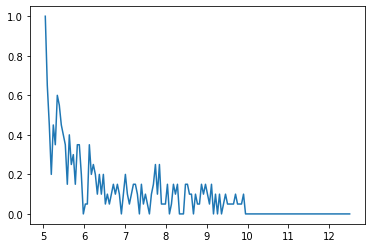

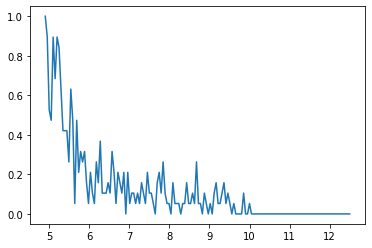

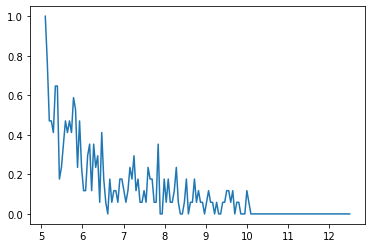

KeyboardInterrupt: 

In [66]:
plot_curve_for_each_pixel(matrix_256)